In [125]:
import numpy as np
from numpy.random import rand
import csv
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import sklearn.linear_model.perceptron as p
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import classification_report,confusion_matrix


In [126]:
#plots the classification report

def show_values(pc, fmt="%.2f", **kw):
    '''
    Heatmap with text in each cell with matplotlib's pyplot
    Source: https://stackoverflow.com/a/25074150/395857 
    By HYRY
    '''
    pc.update_scalarmappable()
    ax = pc.axes
    for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.all(color[:3] > 0.5):
            color = (0.0, 0.0, 0.0)
        else:
            color = (1.0, 1.0, 1.0)
        ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw)


def cm2inch(*tupl):
    '''
    Specify figure size in centimeter in matplotlib
    Source: https://stackoverflow.com/a/22787457/395857
    By gns-ank
    '''
    inch = 2.54
    if type(tupl[0]) == tuple:
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)


def heatmap(AUC, title, xlabel, ylabel, xticklabels, yticklabels, figure_width=40, figure_height=20, correct_orientation=False, cmap='RdBu'):
    '''
    Inspired by:
    - https://stackoverflow.com/a/16124677/395857 
    - https://stackoverflow.com/a/25074150/395857
    '''

    # Plot it out
    fig, ax = plt.subplots()    
    #c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap='RdBu', vmin=0.0, vmax=1.0)
    c = ax.pcolor(AUC, edgecolors='k', linestyle= 'dashed', linewidths=0.2, cmap=cmap)

    # put the major ticks at the middle of each cell
    ax.set_yticks(np.arange(AUC.shape[0]) + 0.5, minor=False)
    ax.set_xticks(np.arange(AUC.shape[1]) + 0.5, minor=False)

    # set tick labels
    #ax.set_xticklabels(np.arange(1,AUC.shape[1]+1), minor=False)
    ax.set_xticklabels(xticklabels, minor=False)
    ax.set_yticklabels(yticklabels, minor=False)

    # set title and x/y labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    # Remove last blank column
    plt.xlim( (0, AUC.shape[1]) )

    # Turn off all the ticks
    ax = plt.gca()    
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # Add color bar
    plt.colorbar(c)

    # Add text in each cell 
    show_values(c)

    # Proper orientation (origin at the top left instead of bottom left)
    if correct_orientation:
        ax.invert_yaxis()
        ax.xaxis.tick_top()       

    # resize 
    fig = plt.gcf()
    #fig.set_size_inches(cm2inch(40, 20))
    #fig.set_size_inches(cm2inch(40*4, 20*4))
    fig.set_size_inches(cm2inch(figure_width, figure_height))



def plot_classification_report(classification_report, title='Classification report ', cmap='RdBu'):
    '''
    Plot scikit-learn classification report.
    Extension based on https://stackoverflow.com/a/31689645/395857 
    '''
    lines = classification_report.split('\n')

    classes = []
    plotMat = []
    support = []
    class_names = []
    for line in lines[2 : (len(lines) - 2)]:
        t = line.strip().split()
        if len(t) < 2: continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        print(v)
        plotMat.append(v)

    print('plotMat: {0}'.format(plotMat))
    print('support: {0}'.format(support))

    xlabel = 'Metrics'
    ylabel = 'Classes'
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup) for idx, sup  in enumerate(support)]
    figure_width = 25
    figure_height = len(class_names) + 7
    correct_orientation = False
    heatmap(np.array(plotMat), title, xlabel, ylabel, xticklabels, yticklabels, figure_width, figure_height, correct_orientation, cmap=cmap)

In [127]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [128]:
def plotacc(performance, labels, dataset):
    
    temp = (labels[0],)
    l = list(temp)
    for i in range(1, len(labels)):
        l.append(labels[i])
        
    objects = tuple(l)
    y_pos = np.arange(len(objects))
     
    my_cmap = cm.get_cmap('jet')
    # get normalize function (takes data in range [vmin, vmax] -> [0, 1])
    my_norm = Normalize(vmin=0, vmax=len(labels))
    # some boring fake data
    my_data = len(labels)*rand(len(labels))
    
    plt.bar(y_pos, performance, align='center', alpha=0.5,color=my_cmap(my_norm(my_data)))
    plt.xticks(y_pos, objects)
    plt.ylabel('Performance')
    plt.title('Performance of different networks on '+dataset)

    plt.savefig('Performance of different networks on '+dataset+'.png')
    plt.show()

In [129]:
#function for SINGLE LAYER PERCEPTRON 

def slp(x_train, x_test, y_train, y_test, class_names, dataset):
    net = p.Perceptron(max_iter=500, verbose=0, random_state=None, fit_intercept=True, eta0=0.002)
    print(net)
    model = net.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = (y_pred==y_test).sum()/len(y_test)
    print('Accuracy on ', dataset,' with single layer perceptron: ',accuracy*100,'%')
    print('Confusion matrix:\n',confusion_matrix(y_test,y_pred))
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
    plt.savefig('confusion matrix  '+dataset+'.png')
    plt.show()
    
    report = classification_report(y_test,y_pred)
    print(report)
    plot_classification_report(report)
    plt.savefig('classif_report '+dataset+'.png', dpi=200, format='png', bbox_inches='tight')
    plt.show()
    
    return accuracy

In [130]:
# function for MULTI LAYER PERCEPTRON (HL = 1)
# nh = ns/(a*(ni+no)) : used here to calculate no. of neurons in hidden layer

def mlp(x_train, x_test, y_train, y_test, nh, method, dataset):
    layers = len(nh)
    nh = tuple(nh)
    
    if method=='c':
        mlp = MLPClassifier(activation = 'logistic', solver='sgd', hidden_layer_sizes=(nh), random_state=1, max_iter = 1000)
    #For small datasets, ‘lbfgs’ can converge faster and perform better.
    #logistic here is the sigmoid activation
        mlp.fit(x_train, y_train)
        plt.plot(mlp.loss_curve_, label = str(layers)+' hidden layer(s)')
        pred = mlp.predict(x_test)
        accuracy = (pred==y_test).sum()/len(y_test)
        
        plt.legend()
        plt.xlabel('iterations')
        plt.ylabel('logistic loss')
        plt.savefig('loss_plot_c '+str(layers)+' layers.png')
        plt.show()
        
        if dataset == "breast-cancer":
            class_names = ['benign', 'malignant']
        elif dataset == "house-votes-84":
            class_names = ['republican', 'democratic']
       
    
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_test, pred)
        np.set_printoptions(precision=2)

        # Plot non-normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
        plt.savefig('Confusion matrix '+dataset+' with'+str(layers)+' layers.png')
        plt.show()
        print('Confusion matrix:\n',confusion_matrix(y_test,pred))

        report = classification_report(y_test, pred)
        print(report)
        plot_classification_report(report)
        plt.savefig('classif_report_mlp '+dataset+' with'+str(layers)+' layers.png', dpi=200, format='png', bbox_inches='tight')
        plt.show()
        
        print('Accuracy on ', dataset,' with multiple layer perceptron having',layers,'layers: ',accuracy*100,'%')
        return accuracy
        
    elif method=='r':
        mlp = MLPRegressor(activation = 'tanh', solver='sgd', hidden_layer_sizes=(nh), random_state=1, max_iter = 1000)
    #For small datasets, ‘lbfgs’ can converge faster and perform better.
    #logistic here is the sigmoid activation
        mlp.fit(x_train, y_train)
        pred = mlp.predict(x_test)
        #pd.DataFrame(mlp.loss_curve_).plot()
        #accuracy = (pred==y_test).sum()/len(y_test)
        errors = y_test - pred
        mean_err = np.mean(errors)
        stddev = np.std(errors)
        f1 = plt.plot(mlp.loss_curve_, label = str(layers)+' hidden layer(s)')
        plt.legend()
        plt.xlabel('iterations')
        plt.ylabel('mse loss')
        plt.savefig('loss_plot_r '+str(layers)+' layers.png')
        plt.show()

        return mean_err, stddev
        
   
    
    

Perceptron(alpha=0.0001, class_weight=None, eta0=0.002, fit_intercept=True,
      max_iter=500, n_iter=None, n_jobs=1, penalty=None, random_state=None,
      shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy on  breast-cancer  with single layer perceptron:  93.56725146198829 %
Confusion matrix:
 [[62  1]
 [10 98]]
Confusion matrix
[[62  1]
 [10 98]]


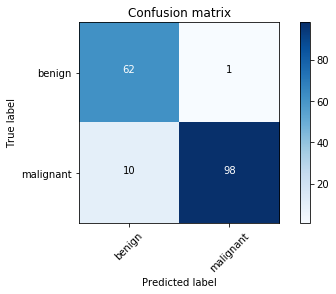

             precision    recall  f1-score   support

          0       0.86      0.98      0.92        63
          1       0.99      0.91      0.95       108

avg / total       0.94      0.94      0.94       171

[0.86, 0.98, 0.92]
[0.99, 0.91, 0.95]
plotMat: [[0.86, 0.98, 0.92], [0.99, 0.91, 0.95]]
support: [63, 108]


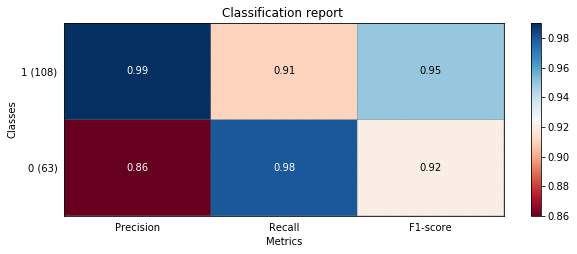

/home/sandipan/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


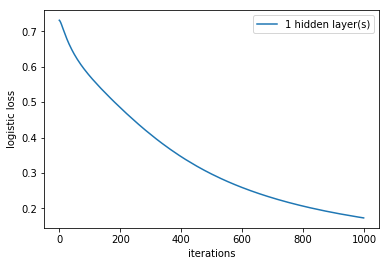

Confusion matrix
[[ 62   1]
 [  2 106]]


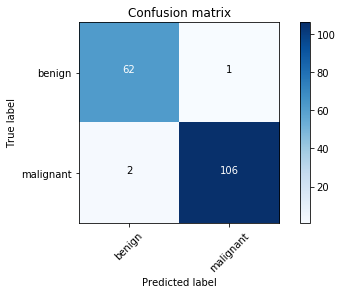

Confusion matrix:
 [[ 62   1]
 [  2 106]]
             precision    recall  f1-score   support

          0       0.97      0.98      0.98        63
          1       0.99      0.98      0.99       108

avg / total       0.98      0.98      0.98       171

[0.97, 0.98, 0.98]
[0.99, 0.98, 0.99]
plotMat: [[0.97, 0.98, 0.98], [0.99, 0.98, 0.99]]
support: [63, 108]


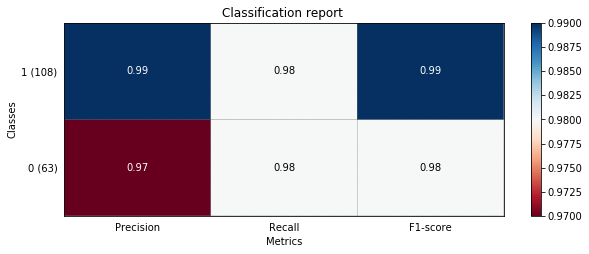

Accuracy on  breast-cancer  with multiple layer perceptron having 1 layers:  98.24561403508771 %


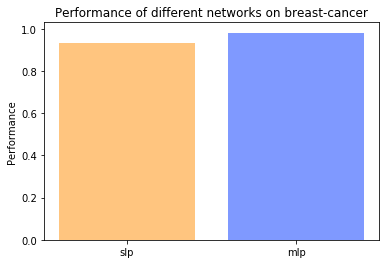

In [131]:
bc = datasets.load_breast_cancer()
data, target = bc.data, bc.target
# target = target.reshape((target.shape[0],1))
# con = np.concatenate((data, target), axis=1)   #used when running LR separately
# random.shuffle(con)
# xval = (int)(data.shape[0]*0.7)
# x_train, y_train = con[:xval,:data.shape[1]], con[:xval,data.shape[1]:]
# x_test, y_test = con[xval:,:data.shape[1]], con[xval:,data.shape[1]:]

x_train_bc, x_test_bc, y_train_bc, y_test_bc = train_test_split(data, target, test_size=0.3, random_state = 42)
scaler = StandardScaler()
scaler.fit(x_train_bc)
x_train_bc = scaler.transform(x_train_bc)
x_test_bc = scaler.transform(x_test_bc)

nh = int(x_train_bc.shape[0]/(2*(x_train_bc.shape[1]+len(np.unique(y_train_bc)))))  #no.of hidden layer neurons

acc_slp = slp(x_train_bc, x_test_bc, y_train_bc, y_test_bc, ['benign', 'malignant'], 'breast-cancer') #slp tested on breast_cancer dataset
acc_mlp = mlp(x_train_bc, x_test_bc, y_train_bc, y_test_bc, [nh], 'c','breast-cancer') #mlp tested on breast_cancer dataset

plotacc([acc_slp,acc_mlp], ['slp','mlp'], 'breast-cancer')

Perceptron(alpha=0.0001, class_weight=None, eta0=0.002, fit_intercept=True,
      max_iter=500, n_iter=None, n_jobs=1, penalty=None, random_state=None,
      shuffle=True, tol=None, verbose=0, warm_start=False)
Accuracy on  house-votes-84  with single layer perceptron:  95.41984732824427 %
Confusion matrix:
 [[40  6]
 [ 0 85]]
Confusion matrix
[[40  6]
 [ 0 85]]


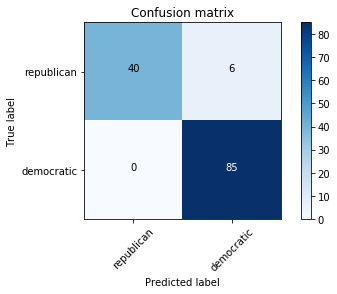

             precision    recall  f1-score   support

          0       1.00      0.87      0.93        46
          1       0.93      1.00      0.97        85

avg / total       0.96      0.95      0.95       131

[1.0, 0.87, 0.93]
[0.93, 1.0, 0.97]
plotMat: [[1.0, 0.87, 0.93], [0.93, 1.0, 0.97]]
support: [46, 85]


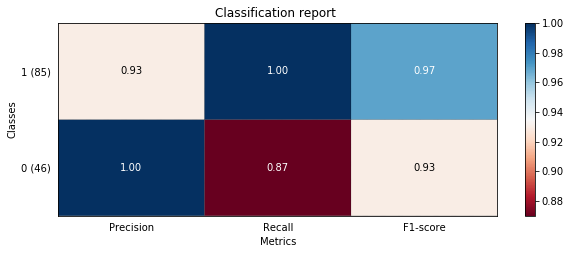

/home/sandipan/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


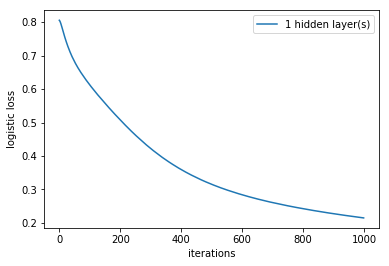

Confusion matrix
[[41  5]
 [ 3 82]]


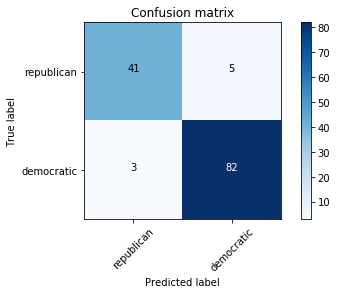

Confusion matrix:
 [[41  5]
 [ 3 82]]
             precision    recall  f1-score   support

          0       0.93      0.89      0.91        46
          1       0.94      0.96      0.95        85

avg / total       0.94      0.94      0.94       131

[0.93, 0.89, 0.91]
[0.94, 0.96, 0.95]
plotMat: [[0.93, 0.89, 0.91], [0.94, 0.96, 0.95]]
support: [46, 85]


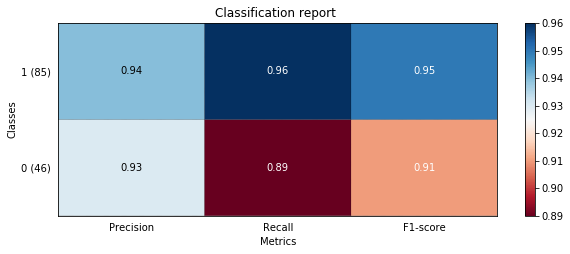

Accuracy on  house-votes-84  with multiple layer perceptron having 1 layers:  93.89312977099237 %


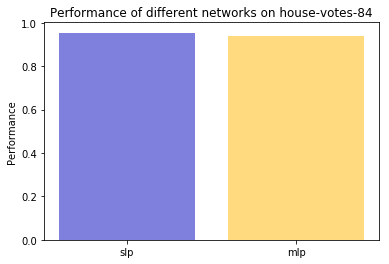

In [132]:

with open('/home/sandipan/ml/house-votes-data.csv') as file:
    next(file)                      #to ignore header of csv file
    reader = csv.reader(file, delimiter = ',')
    x = list(reader)
    data1 = np.array(x).astype("int")

target1 = data1[:,data1.shape[1]-1]
data1 = data1[:,:data1.shape[1]-1]
x_train_hv, x_test_hv, y_train_hv, y_test_hv = train_test_split(data1, target1, test_size=0.3, random_state = 42)

nh = int(x_train_hv.shape[0]/(2*(x_train_hv.shape[1]+len(np.unique(y_train_hv)))))  #no.of hidden layer neurons

acc_slp = slp(x_train_hv, x_test_hv, y_train_hv, y_test_hv, ['republican', 'democratic'],'house-votes-84') #slp tested on house_votes_84 dataset
acc_mlp = mlp(x_train_hv, x_test_hv, y_train_hv, y_test_hv, [nh], 'c', 'house-votes-84') #mlp tested on house_votes_84 dataset

plotacc([acc_slp,acc_mlp], ['slp','mlp'], 'house-votes-84')

/home/sandipan/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


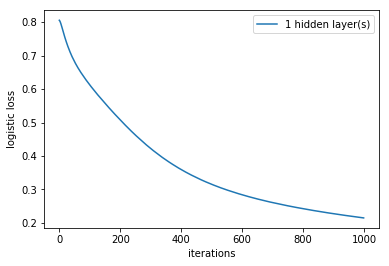

Confusion matrix
[[41  5]
 [ 3 82]]


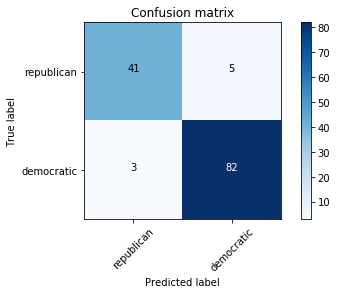

Confusion matrix:
 [[41  5]
 [ 3 82]]
             precision    recall  f1-score   support

          0       0.93      0.89      0.91        46
          1       0.94      0.96      0.95        85

avg / total       0.94      0.94      0.94       131

[0.93, 0.89, 0.91]
[0.94, 0.96, 0.95]
plotMat: [[0.93, 0.89, 0.91], [0.94, 0.96, 0.95]]
support: [46, 85]


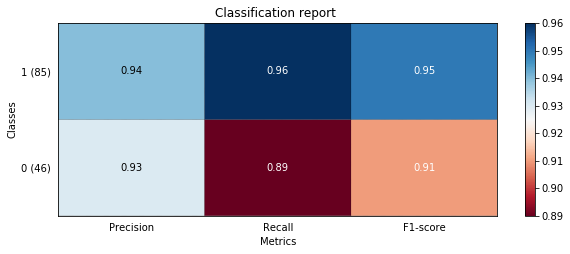

Accuracy on  house-votes-84  with multiple layer perceptron having 1 layers:  93.89312977099237 %


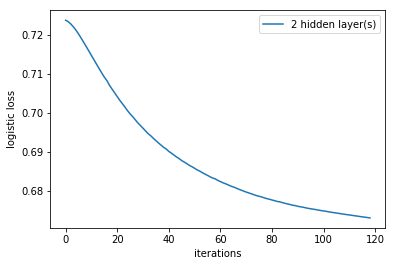

Confusion matrix
[[ 0 46]
 [ 0 85]]


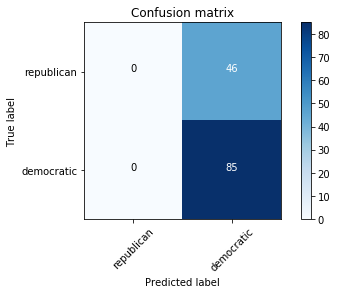

Confusion matrix:
 [[ 0 46]
 [ 0 85]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        46
          1       0.65      1.00      0.79        85

avg / total       0.42      0.65      0.51       131

[0.0, 0.0, 0.0]
[0.65, 1.0, 0.79]
plotMat: [[0.0, 0.0, 0.0], [0.65, 1.0, 0.79]]
support: [46, 85]


/home/sandipan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


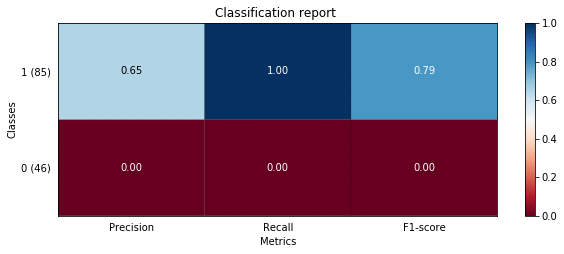

Accuracy on  house-votes-84  with multiple layer perceptron having 2 layers:  64.8854961832061 %


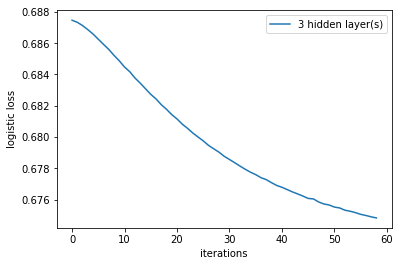

Confusion matrix
[[ 0 46]
 [ 0 85]]


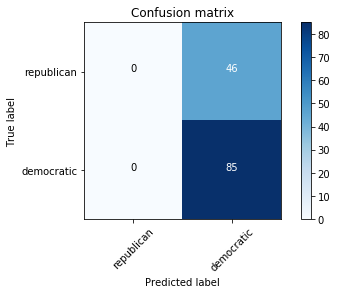

Confusion matrix:
 [[ 0 46]
 [ 0 85]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        46
          1       0.65      1.00      0.79        85

avg / total       0.42      0.65      0.51       131

[0.0, 0.0, 0.0]
[0.65, 1.0, 0.79]
plotMat: [[0.0, 0.0, 0.0], [0.65, 1.0, 0.79]]
support: [46, 85]


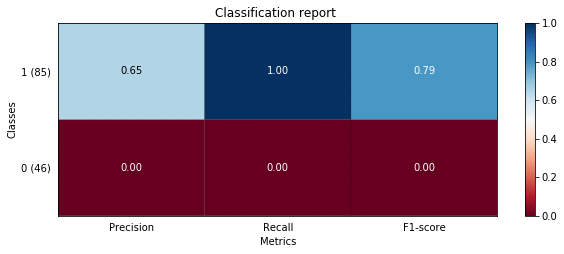

Accuracy on  house-votes-84  with multiple layer perceptron having 3 layers:  64.8854961832061 %


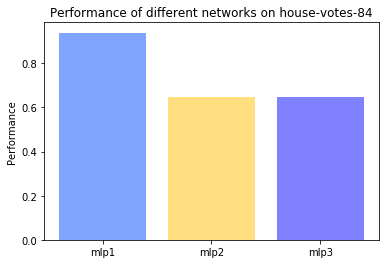

In [133]:
#comparing with 1hl, 2hl, and 3hl mlps

nh = int(x_train_hv.shape[0]/(2*(x_train_hv.shape[1]+len(np.unique(y_train_hv)))))  #no.of hidden layer neurons

acc_mlp1 = mlp(x_train_hv, x_test_hv, y_train_hv, y_test_hv, [nh], 'c', 'house-votes-84') #mlp tested on house_votes_84 dataset
acc_mlp2 = mlp(x_train_hv, x_test_hv, y_train_hv, y_test_hv, [nh,nh], 'c', 'house-votes-84') #mlp tested on house_votes_84 dataset
acc_mlp3 = mlp(x_train_hv, x_test_hv, y_train_hv, y_test_hv, [nh, nh, nh], 'c', 'house-votes-84') #mlp tested on house_votes_84 dataset

plotacc([acc_mlp1,acc_mlp2, acc_mlp3], ['mlp1','mlp2', 'mlp3'], 'house-votes-84')

In [134]:
def one_hot_encode(data, rows, cols, cat):
    allcodes = []
    flag = 1
    for col in range(cols):               #finding unique values of each attribute and generating mappings
        dvals = []
        codes = []
        count = 0
        for row in range(cat.shape[0]):
            if cat.iloc[row][col] not in dvals:
                dvals.append(cat.iloc[row][col])
                cat.iloc[row][col] = count
                codes.append(count)
                count = count+1

            else:
                obj = cat.iloc[row][col]
                cat.iloc[row][col] = codes[dvals.index(obj)]

        allcodes.append(codes)


    for j in range(len(allcodes)):          #creating separate attributes for each unique value ini each attribute
                                            #and encoding into one-hot
        temp = np.zeros((rows,len(allcodes[j])))
        l = []
        for k in range(len(allcodes[j])):
            s = cat.columns[j]+'_'+str(k)
            l.append(s)

        new = pd.DataFrame(data=temp[:,:], columns=l)
        for i in range(rows):
            val = cat.iloc[i][j]
            new.iloc[i][val] = 1

        if flag==1:
            old = new.copy()
        else:
            cop = new.copy()
            old = pd.concat([old, cop], axis=1).copy()
        flag=0    

    data = pd.concat([data, old], axis=1)
    
    return data          # new one-hot encoded categorical attributes are now concatenated with previous attributes
                         # and returned


In [135]:
#testing on HOUSE PRICING DATASET

df = pd.read_csv('/home/sandipan/ml/train.csv')
r, c = df.shape
data = df.iloc[:,1:c-1]
target = df.iloc[:, c-1]
cat = df.select_dtypes(include=['object'])
data = data.select_dtypes(exclude=['object'])

rows, cols = cat.shape


oh_data = one_hot_encode(data, rows, cols, cat)          #manually encoding categorical attributes to one-hot
print(oh_data)


      MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0     8450            7            5       2003   
1             20         80.0     9600            6            8       1976   
2             60         68.0    11250            7            5       2001   
3             70         60.0     9550            7            5       1915   
4             60         84.0    14260            8            5       2000   
5             50         85.0    14115            5            5       1993   
6             20         75.0    10084            8            5       2004   
7             60          NaN    10382            7            6       1973   
8             50         51.0     6120            7            5       1931   
9            190         50.0     7420            5            6       1939   
10            20         70.0    11200            5            5       1965   
11            60         85.0    11924            9 

1314 1315


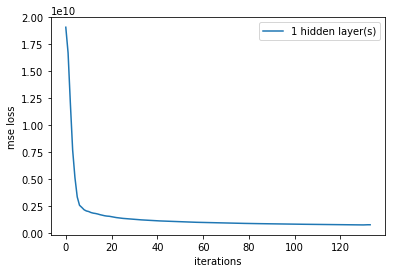

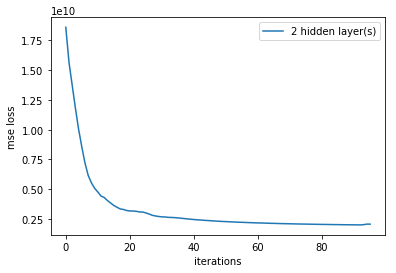

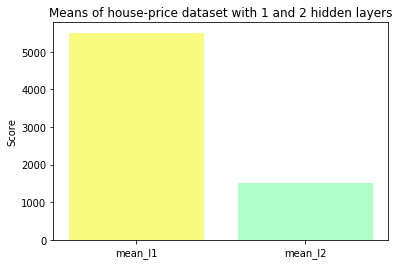

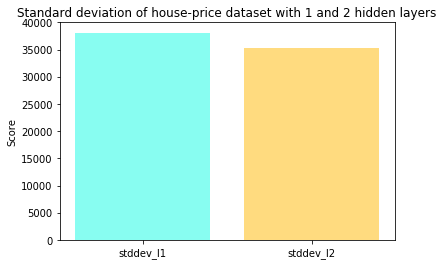

mean_l1:  5506.382297676898 ; mean_l2:  1515.0467577877623 

stddev_l1:  38080.337097043455 ; stddev_l2:  35199.19996072644 



In [136]:
#10-fold cross validation

# k = 10
oh_data = oh_data.fillna(0)
new_data = oh_data.values.astype("float64")
scaler = StandardScaler()
scaler.fit(new_data)
new_data = scaler.transform(new_data)
# kf = KFold(n_splits = k, shuffle = True)
# cv = kf.split(new_data)
tr = int(0.9*new_data.shape[0])
tt = tr+1
print(tr, tt)
x_train, x_test = new_data[0:tr,:], new_data[tt:,:]
y_train, y_test = target.iloc[0:tr], target.iloc[tt:]

m1, s1 = mlp(x_train, x_test, y_train, y_test, [x_train.shape[1]], 'r', 'house-price') # mlp tested on 
m2, s2 = mlp(x_train, x_test, y_train, y_test, [x_train.shape[1], x_train.shape[1]], 'r', 'house-price') # house_price dataset

objects = ('mean_l1', 'mean_l2')
y_pos = np.arange(len(objects))
performance = [m1, m2]
my_cmap = cm.get_cmap('jet')
# get normalize function (takes data in range [vmin, vmax] -> [0, 1])
my_norm = Normalize(vmin=0, vmax=2)
# some boring fake data
my_data = 2*rand(2)

f2 = plt.bar(y_pos, performance, align='center', alpha=0.5,color=my_cmap(my_norm(my_data)))
plt.xticks(y_pos, objects)
plt.ylabel('Score')
plt.title('Means of house-price dataset with 1 and 2 hidden layers')
plt.savefig('Means of house-price dataset with 1 and 2 hidden layers.png')
plt.show()

objects = ('stddev_l1', 'stddev_l2')
y_pos = np.arange(len(objects))
performance = [s1, s2]
my_cmap = cm.get_cmap('jet')
# get normalize function (takes data in range [vmin, vmax] -> [0, 1])
my_norm = Normalize(vmin=0, vmax=2)
# some boring fake data
my_data = 2*rand(2)

f2 = plt.bar(y_pos, performance, align='center', alpha=0.5,color=my_cmap(my_norm(my_data)))
plt.xticks(y_pos, objects)
plt.ylabel('Score')
plt.title('Standard deviation of house-price dataset with 1 and 2 hidden layers')
plt.savefig('stddev of house-price dataset with 1 and 2 hidden layers.png')
plt.show()

print("mean_l1: ",m1,"; mean_l2: ",m2,"\n")
print("stddev_l1: ",s1,"; stddev_l2: ",s2,"\n")
# plotacc([loss1,loss2], ['mlp1','mlp2'], 'house-price')